## Idea: Analyse MP item metadata, find out overall metadata coverage, identify items with low metadata quality

This process has four steps:
1. Fetch all relevant data from SSHOP
2. Extract metadata
3. Compare against SSHOPMP metdata guidelines
4. Find (and flag) items with low metadata quality

In [2]:
import pandas as pd #to manage dataframes
import matplotlib.pyplot as plt #to create histograms and images
import seaborn as sns #to create histograms and images #still needed?
import json #to manage json objects
#import the MarketPlace Library 
from sshmarketplacelib import MPData as mpd
from sshmarketplacelib import  eval as eva, helper as hel
import requests

## 1. Use the sshmarketplacelib to get all tools and services

In [3]:
### Start with Tools and Services
mpdata = mpd()
df_tool_flat =mpdata.getMPItems ("toolsandservices", True)

getting data from local repository...


In [106]:
df_tool_flat.transpose()

,0,1,2,3,4,5,6,7,8,9,...,2039,2040,2041,2042,2043,2044,2045,2046,2047,2048
id,56619,36324,51323,36189,36213,52537,58692,52541,56623,36528,...,60286,47493,54931,58318,27963,60298,58321,58323,47504,54613
category,tool-or-service,tool-or-service,tool-or-service,tool-or-service,tool-or-service,tool-or-service,tool-or-service,tool-or-service,tool-or-service,tool-or-service,...,tool-or-service,tool-or-service,tool-or-service,tool-or-service,tool-or-service,tool-or-service,tool-or-service,tool-or-service,tool-or-service,tool-or-service
label,140kit,3DF Zephyr - photogrammetry software - 3d mode...,3DHOP: 3D Heritage Online Presenter,3DReshaper \| 3DReshaper,"3ds Max \| 3D Modeling, Animation \& Rendering...",3DVIA Virtools,4th Dimension,80legs,960 Grid System,A360 \| Project Collaboration in the Cloud,...,Zenodo,ZingChart,Zoho,Zoomerang,Zoomify,Zotero,ZotFile,Zotpress,Zubrag HTML Tags Stripper,Αpollonis infrastructure services
persistentId,SIU1nO,4gDAHv,OgfTLA,kAkzuz,9NKBY5,zrfCly,rdwzoM,XsXzlp,uo4gCA,qbhnQw,...,SA186o,TeJcir,lTzxxa,CHiTf9,NR5Mbp,dY3lIq,KlkkWa,YoTO6a,I1kFsQ,1d7ee5
lastInfoUpdate,2023-10-17T09:58:17+0000,2022-01-13T11:49:02+0000,2023-07-26T12:25:13+0000,2022-01-13T11:47:44+0000,2022-01-13T11:47:53+0000,2023-10-06T08:00:41+0000,2023-10-17T10:48:27+0000,2023-10-06T08:00:43+0000,2023-10-17T09:58:20+0000,2022-01-13T11:50:22+0000,...,2023-10-18T08:50:00+0000,2022-11-03T15:23:41+0000,2023-10-06T08:32:43+0000,2023-10-17T10:13:55+0000,2021-11-23T17:19:03+0000,2023-10-18T08:50:07+0000,2023-10-17T10:13:57+0000,2023-10-17T10:13:58+0000,2022-11-03T15:23:48+0000,2023-10-06T08:16:13+0000
status,approved,approved,approved,approved,approved,approved,approved,approved,approved,approved,...,approved,approved,approved,approved,approved,approved,approved,approved,approved,approved
description,140kit provides a management layer for tweet c...,3DF Zephyr\[1\]\[2\] is a commercial photogram...,3DHOP (3D Heritage Online Presenter) is an op...,No description provided.,"3ds Max is software for 3D modeling, animation...",A software tool for the creation of 3D interac...,4th Dimension is a graphic environment for dev...,80legs is a web crawling service. You need to ...,960 Grid System is a CSS template that comes w...,"A360 helps design, engineering, and project te...",...,Zenodo is a catch-all repository for research ...,JavaScript Charts\n\nThe developer's solution ...,Zoho provides a drag-and-drop interface for cr...,Zoomerang is online survey software. Users cre...,A suite of products developed for web designer...,"Zotero is a free tool that collects, manages a...",Zotero add-on for Firefox to manage your attac...,Zotpress is a WordPress plugin that enables us...,This tool simply takes HTML and returns it wit...,"Services & tools, resources and user guides of..."
contributors,"[{'actor': {'id': 2224, 'name': 'Ian Pearce, D...",[],"[{'actor': {'id': 9747, 'name': 'Marco Callier...",[],[],"[{'actor': {'id': 1925, 'name': 'Dassault Syst...",[],"[{'actor': {'id': 2373, 'name': '80legs', 'ext...",[],[],...,"[{'actor': {'id': 335, 'name': 'CERN', 'extern...","[{'actor': {'id': 671, 'name': 'ZingChart, Inc...","[{'actor': {'id': 272, 'name': 'Zoho', 'extern...","[{'actor': {'id': 2842, 'name': 'N/A', 'extern...","[{'actor': {'id': 218, 'name': 'Zoomify Inc.',...",[],"[{'actor': {'id': 2624, 'name': 'Joscha Legewi...","[{'actor': {'id': 455, 'name': 'Katie Seaborn'...","[{'actor': {'id': 2842, 'name': 'N/A', 'extern...","[{'actor': {'id': 3502, 'name': 'DARIAH-GR / D..."
properties,"[{'type': {'code': 'mode-of-use', 'label': 'Mo...","[{'type': {'code': 'language', 'label': 'Langu...","[{'type': {'code': 'language', 'label': 'Langu...","[{'type': {'code': 'language', 'label': 'Langu...","[{'type': {'code': 'language', 'label': 'Langu...","[{'type': {'code': 'keyword', 'label': 'Keywor...","[{'type': {'code': 'terms-of-use', 'label': 'T...","[{'type': {'code': 'terms-of-use', 'label': 'T...","[{'type': {'code': 'terms-of-use', 'label': 'T...","[{'type

In [125]:
df_tool_flat.to_pickle('MDscore.pickle') #save df to file

## 2. Extract Metadata
I am following the SSHOP Metadata Guidelines here https://marketplace.sshopencloud.eu/contribute/metadata-guidelines to identify the following recommended metadata fields for tools and services:

**Generic Metadata**
- label -> Label is **mandatory**, meaning items must have a label. It makes no sense to check for it seperately here.
- description -> Description is also mandatory, but some items only have texts like "no description provided". These placeholder values should be treated as no description
- actor -> can be cecked, including actor association and actor identifyer
- accessibleAt -> check if an item has a URL here, and if it is available
- externalID -> check if a value is present here
- media -> check if item has media items 
- thumbnail -> check if item has a *custom* thumbnail. 
- relatedItems -> check if there are any related items

**Categorisation metadata**
- activity -> check if there is at least one activity connected to the item
- keyword -> check if there is at least one keyword
- discipline -> check if there is at least one discipline
- language -> check for an entry in the language field
- mode-of-use -> check for entry in this field
- IntendedAudience -> check for entry in this field
- standard -> check for entry in this field
- resource-category -> check for entry in this field

**Context metadata**
- see-also -> check for entry in this field
- usermanual-url -> check for entry in this field
- helpdesk-url -> check for entry in this field

**Access metadata**
- license -> check for entry in this field
- termsofuse-url -> check for entry in this field

**Bibliographic metadata**

*No recommended fields here for Tools and Services, skipping this section*

**Technical metadata**
- technical-readiness-level -> check for entry in this field
- version -> check for entry in this field

Some of these fields can be true or false (for example, thumbnails can exist or not), others can take multiple values. RelatedItems for example can be any number of items. For this basic check, having at least one value in a field will pass the test. For a more advanced test, the actual ammount of items in a field can be compared with the average ammount for this item type. 

The accessibleAt URL can be checked to see if the URL is available. This takes a while if the query is run across the whole SSHOMP. There are three more fields with URLS, usermanual-url,  helpdesk-url and termsofuse-url. To save time, the status of these URLs is not being checked.

This function gets all properties relevant for the metadata mentioned above. The way metadata is structured in the API response is not compliant with the described metadata structure. Especially the six categories general, categorization, context, access, bibliographic and technical do not exist in the API response. 
The function gets all properties that are relevant for the analysis at some point. Another check can filter out the desired values later

In [127]:
def check_properties(id): #almost all the MD we are interested in is in the properties. This function parses the properties as a dict for easier inspection
    target_row = df_tool_flat.loc[df_tool_flat['persistentId'] == id]
    properties = (target_row['properties'].item()) #change so it outputs all codes
    activity = sum(1 for i in properties if i['type']['code'] == 'activity')
    keywords = sum(1 for i in properties if i['type']['code'] == 'keyword')
    discipline = sum(1 for i in properties if i['type']['code'] == 'discipline')
    language = sum(1 for i in properties if i['type']['code'] == 'language')
    tool_family = sum(1 for i in properties if i['type']['code'] == 'tool-family')
    modeofuse = sum(1 for i in properties if i['type']['code'] == 'mode-of-use')
    intended_audience = sum(1 for i in properties if i['type']['code'] == 'intended-audience')
    see_also = sum(1 for i in properties if i['type']['code'] == 'see-also')
    user_manual_url = sum(1 for i in properties if i['type']['code'] == 'user-manual-url')
    helpdesk_url = sum(1 for i in properties if i['type']['code'] == 'helpdesk-url')
    license = sum(1 for i in properties if i['type']['code'] == 'license')
    terms_of_use_url = sum(1 for i in properties if i['type']['code'] == 'terms-of-use-url')#count the items like this
    technical_readiness_level = sum(1 for i in properties if i['type']['code'] == 'technical-readiness-level')
    resource_category = sum(1 for i in properties if i['type']['code'] == 'resource-category')
    version = sum(1 for i in properties if i == 'version')
    properties = {"activity":activity, 
                  "keywords": keywords, 
                  "discipline": discipline, 
                  "language": language,
                  "tool-family": tool_family, 
                  "mode of use": modeofuse, 
                  "intended audience": intended_audience, 
                  "see also": see_also, 
                  "user manual URL": user_manual_url, 
                  "helpdesk URL":helpdesk_url, 
                  "license":license, 
                  "terms of use URL": terms_of_use_url, 
                  "technical readiness level":technical_readiness_level, 
                  "resource category": resource_category, 
                  "version": version}
    return properties

This function gets the number of contributors, external IDs and affiliations

In [128]:
def check_contributors(id):
    target_row = df_tool_flat.loc[df_tool_flat['persistentId'] == id]
    contributors = (target_row['contributors'].item())
    external = sum(1 for i in contributors if i['actor']['externalIds'])
    affiliations = sum(1 for i in contributors if i['actor']['affiliations'])
    contributors_count = len(contributors)
    contributors = {"contributors":contributors_count, "external ids": external, "affiliations":affiliations}
    return contributors

This function gets the external IDs for a Tool and returns the number

In [129]:
def check_external_ids(persID):
    target_row = df_tool_flat.loc[df_tool_flat['persistentId'] == persID]
    external_ids = (target_row['externalIds'].item())
    return(len(external_ids))

This function gets the number of related items and returns the number of related items

In [131]:
def check_related_items(persID):
    target_row = df_tool_flat.loc[df_tool_flat['persistentId'] == persID]
    related_items = (target_row['relatedItems'].item())
    return(len(related_items))

This function gets the number of media items and returns their number

In [132]:
def check_media(persID):
    target_row = df_tool_flat.loc[df_tool_flat['persistentId'] == persID]
    media = (target_row['media'].item())
    return(len(media))

This function checks an item's desription. If it is a placeholder like "No description provided", it is treated as having no description. The function returns the length of the description.

In [133]:
def check_description(persID):
    target_row = df_tool_flat.loc[df_tool_flat['persistentId'] == persID]
    description = (target_row['description'].item())
    if description == 'No description provided.': #description can not be empty, but some items use "No description provided." to get around this.
        return 0
    else:
        return len(description)

This function checks the URLs and their availability. It returns the URLs status, or "No URL".

In [18]:
def check_accessibleAt(persId): #checks urls
    target_row = df_tool_flat.loc[df_tool_flat['persistentId'] == persId]
    url = (target_row['accessibleAt'].item())
    url_status = {}
    if len(url) == 0:
        url_status = 'No URL'
    for i in url:
        try:
            status = requests.head(i, timeout=10).status_code
            if status == 200:
                url_status.update({i: "available"})
            elif status != 200:
                url_status.update({i: "unavailable"})
        except:
            url_status.update({i: "unavailable"})
    return url_status

This function checks the number of external IDs and returns this number

In [19]:
def check_external_Ids(persId):
    target_row = df_tool_flat.loc[df_tool_flat['persistentId'] == persId]
    external_Ids = len((target_row['externalIds'].item()))
    return external_Ids

This function checks if the item has a custom thumbnail. It returns true or false

In [20]:
def check_thumbnail(persId):
    target_row = df_tool_flat.loc[df_tool_flat['persistentId'] == persId]
    thumbnail = target_row['thumbnail.info.mediaId'].item()
    if pd.isna(thumbnail) == False:
        return True
    else:
        return False

Now this basic check uses the above functions to check metadata across the six categories. 


For most metadata fields, this can be done by checking if the number of entries returned by the functions is not 0. For the description, the lenght is checked and evaluated here. 
Since the check_properties function returns all relevant properties, we need to filter down the returned values for each category. 
This is done by defining the relevant values like so 
`cat_md = ('activity', 'keywords',"discipline","language", "mode of use", "intended audience", "resource category")`
and then filtering the output of check_properties:
`score_cat = {key: check_properties(persId)[key] for key in cat_md}`
the check goes through all defined metadata fields and returns a dictionary like this

>`{'flag_description': False,
 'flag_contributors': False,
 'flag_accessibleAt': False,
 'flag_external_Ids': True,
 'flag_media': False,
 'flag_thumbnail': True,
 'flag_related_items': True,
 'activity': 7,
 'keywords': 3,
 'discipline': 0,
 'language': 0,
 'mode of use': 1,
 'intended audience': 0,
 'resource category': 0,
 'helpdesk URL': 0,
 'see also': 0,
 'user manual URL': 0,
 'license': 0,
 'technical readiness level': 0,
 'version': 0}
`

Each category gets its own score, which is combined into an overall score:

`int_generic = sum(1 for i in score_generic.values() if i == True)
    int_cat = sum(1 for i in score_cat.values() if i != 0)`

`Overall score: 6 max 21`

The function has a verbose option which can be activated by passing True after the SSHOMP persId:

`basic_check('SIU1nO', True)`

This is helpful to immediately get the stats for a single tool. When running this function across a large number of tools, it is better to keep verbose off.

In [135]:
def basic_check(persId, verbose):
    verboseprint = print if verbose else lambda *a, **k: None
    print ('Running basic check for SSHOMP ID '+persId)
    verboseprint('test')
    #Checking generic MD
    score_generic = {'flag_description' : False,'flag_contributors': False, 'flag_accessibleAt' : False, 'flag_external_Ids' : False, 'flag_media': False, 'flag_thumbnail': False, 'flag_related_items' : False }
    #description
    if check_description(persId) == 0:
        verboseprint('This item has no description')
        score_generic |= ({'flag_description' : True})
    if 0 <= check_description(persId) <= 100:
        verboseprint('This item has very little description')
        score_generic |= ({'flag_description' : True})
    if 101 <= check_description(persId) <= 600:
        verboseprint('This item has a short description')
    if 601 <= check_description(persId) <= 1000:
        verboseprint("This item's description is within the expected range")
    elif 1001 <= check_description(persId):
        verboseprint("This item's description is very long")
        score_generic |= ({'flag_description' : True})
    #actors
    #check actors and contributors
    if len(check_contributors(persId)) == 0:
        verboseprint('This item has no listed contributors')
        score_generic |= ({'flag_contributors' : True})
    else: 
        verboseprint('This item has '+str(len(check_contributors(persId))) +' contributors, of which '+ str(check_contributors(persId)['external ids']) + ' are linked to an external ID and '+ str(check_contributors(persId)['affiliations']) + ' are affiliated with an institution.')
    #check accessibleAt
    if check_accessibleAt(persId) == 'No URL':
        verboseprint('This item has no accessibleAt value')
        score_generic |= ({'flag_accessibleAt' : True})
    else:
        if len(check_accessibleAt(persId)) == sum(value == "available" for value in check_accessibleAt(persId).values()):
            verboseprint ('This item has '+ str(len(check_accessibleAt(persId))) + ' URL, all are available.')
        else:
            verboseprint('This item has '+str(len(check_accessibleAt(persId))) + ' accessibleAt URLS, '+ str(sum(value == "unavailable" for value in check_accessibleAt(persId).values())) +' are available.')
            score_generic |= ({'flag_accessibleAt' : True})
    #check external_IDs
    if check_external_Ids(persId) == 0:
        verboseprint('The item has no external IDs')
        score_generic |= ({'flag_external_Ids' : True})
    else:
        verboseprint ('The item has '+ str(check_external_Ids(persId)) +' external IDs.')
    #check media
    if check_media(persId) == 0:
        verboseprint('The item has no media attached')
        score_generic |= ({'flag_media' : True})
    else:
        verboseprint ('The item has '+ str(check_external_Ids(persId)) +' media items.')
    #Check thumbnail
    if check_thumbnail(persId) == True:
        verboseprint('Item has a thumbnail picture')
    else:
        verboseprint('Item has no thumbnail picture')
        score_generic |= ({'flag_thumbnail' : True})
    #check related items
    if check_related_items(persId) == 0:
        verboseprint('Item has no related items')
        score_generic |= ({'flag_related_items' : True})
    else:
        verboseprint('Item has '+ str(check_related_items(persId))+' related items')
    # now add acore for generic MD
    verboseprint('This item meets the requirements for '+(str(sum(1 for i in score_generic.values() if i == True)))+ ' out of '+ str(len(score_generic)) +' generic metadata fields'+'\n******')
    #categorization metadata
    cat_md = ('activity', 'keywords',"discipline","language", "mode of use", "intended audience", "resource category")
    score_cat = {key: check_properties(persId)[key] for key in cat_md} #runs the "check_properties' function and then filters the output based on what is set in 'cat'
    verboseprint('The item has the following categorization metadata:')
    for k,v in score_cat.items():
        verboseprint(k,v)
    verboseprint('This item meets the requirements for '+(str(sum(1 for i in score_cat.values() if i != 0)))+ ' out of '+ str(len(score_cat)) +' categorization metadata fields'+'\n******')
    #now context MD
    context_md= {'see also', 'user manual URL', 'helpdesk URL'}
    score_cont = {key: check_properties(persId)[key] for key in context_md}
    verboseprint('The item has the following context metadat:')
    for k,v in score_cont.items():
        verboseprint(k,v)
    verboseprint('This item meets the requirements for '+(str(sum(1 for i in score_cont.values() if i != 0)))+ ' out of '+ str(len(score_cont)) +' categorization metadata fields'+'\n******')
    #now access metadata
    access_md={'license', 'see also'}
    score_access = {key: check_properties(persId)[key] for key in access_md}
    verboseprint('The item has the following access metadat:')
    for k,v in score_access.items():
        verboseprint(k,v)
    verboseprint('This item meets the requirements for '+(str(sum(1 for i in score_access.values() if i != 0)))+ ' out of '+ str(len(score_access)) +' access metadata fields'+'\n******')
    #now tecnical metadata
    technical_md = {"technical readiness level", 'version'}
    score_technical = {key: check_properties(persId)[key] for key in technical_md}
    verboseprint('The item has the following technical metadat:')
    for k,v in score_technical.items():
        verboseprint(k,v)
    verboseprint('This item meets the requirements for '+(str(sum(1 for i in score_technical.values() if i != 0)))+ ' out of '+ str(len(score_technical)) +' technical metadata fields'+'\n')
    #now add all the scores and output
    int_generic = sum(1 for i in score_generic.values() if i == True)
    int_cat = sum(1 for i in score_cat.values() if i != 0)
    int_cont= sum(1 for i in score_cont.values() if i != 0)
    int_access = sum(1 for i in score_access.values() if i != 0)
    int_technical = sum(1 for i in score_technical.values() if i != 0)
    total = int_generic + int_cat + int_cont + int_access + int_technical
    max = len(score_generic)+len(score_cat)+len(score_cont)+len(score_access)+len(score_technical)
    #overall_score = {score_generic, score_cat, score_cont, score_access, score_technical}
    overall_score = {**score_generic, **score_cat, **score_cont, **score_access, **score_technical}
    print('Overall score: '+str(total) +' max '+str(max))
    return overall_score
basic_check('SIU1nO', False)

Running basic check for SSHOMP ID SIU1nO
Overall score: 6 max 21


{'flag_description': False,
 'flag_contributors': False,
 'flag_accessibleAt': False,
 'flag_external_Ids': True,
 'flag_media': False,
 'flag_thumbnail': True,
 'flag_related_items': True,
 'activity': 7,
 'keywords': 3,
 'discipline': 0,
 'language': 0,
 'mode of use': 1,
 'intended audience': 0,
 'resource category': 0,
 'helpdesk URL': 0,
 'see also': 0,
 'user manual URL': 0,
 'license': 0,
 'technical readiness level': 0,
 'version': 0}

In [ ]:
df_tool_flat['md_score']=df_tool_flat['persistentId'].apply(basic_check, args=(False,)) #careful, takes a while

Once the function evaluated all Tools&Service items in the MP, we want to be able to quickly get the values per category for all items. This function takes the score that is returned by the previous function and summarizes it according to the six categories:

`{'generic metadata': 4,
 'categorization metadata': 3,
 'access metadata': 0,
 'technical metadata': 0,
 'total': 7,
 'max': 21}
 `

It does so by comparing the score dictionary with the category:

`context_md= {'see also', 'user manual URL', 'helpdesk URL'}`

`filtered_context_score = {key: score.item()[key] for key in context_md}`

`int_cont= sum(1 for i in filtered_context_score.values() if i != 0)`


In [137]:
def score_breakdown(persId):
    target_row = df_tool_flat.loc[df_tool_flat['persistentId'] == persId]
    #General MD Score
    score_generic = {'flag_description' : False,'flag_contributors': False, 'flag_accessibleAt' : False, 'flag_external_Ids' : False, 'flag_media': False, 'flag_thumbnail': False, 'flag_related_items' : False }
    score = target_row['md_score']
    filtered_md_score = {key: score.item()[key] for key in score_generic}
    int_generic = sum(not value for value in filtered_md_score.values())
    #print("General metadata score:", int_generic)
    #Categorization Score
    cat_md = ('activity', 'keywords',"discipline","language", "mode of use", "intended audience", "resource category")
    filtered_cat_score = {key: score.item()[key] for key in cat_md}
    int_cat = sum(1 for i in filtered_cat_score.values() if i != 0)
    #print("Categorization metadata score:", int_cat)
    #context score
    context_md= {'see also', 'user manual URL', 'helpdesk URL'}
    filtered_context_score = {key: score.item()[key] for key in context_md}
    int_cont= sum(1 for i in filtered_context_score.values() if i != 0)
    #print("Contextualization metadata score:", int_cont)
    #Access Score
    access_md={'license', 'see also'}
    filtered_access_score = {key: score.item()[key] for key in access_md}
    int_access = sum(1 for i in filtered_access_score.values() if i != 0)
    #print("Access metadata score:", int_access)
    #technical MD
    technical_md = {"technical readiness level", 'version'}
    filtered_technical_score = {key: score.item()[key] for key in technical_md}
    int_technical = sum(1 for i in filtered_technical_score.values() if i != 0)
    #print("Technical metadata score:", int_technical)
    #total score
    total = int_generic + int_cat + int_cont + int_access + int_technical
    max = len(score_generic)+len(cat_md)+len(context_md)+len(access_md)+len(technical_md)
    #print('Total: '+str(total) +'/'+ str(max))
    output_score = {'generic metadata': int_generic, 'categorization metadata': int_cat, 'access metadata': int_access, 'context metadata':int_cont,'technical metadata': int_technical, 'total':total, 'max':max}
    return output_score
score_breakdown('SIU1nO')

{'generic metadata': 4,
 'categorization metadata': 3,
 'access metadata': 0,
 'context metadata': 0,
 'technical metadata': 0,
 'total': 7,
 'max': 21}

## Step 4: Describe overall metadata quality and find items with low metadata quality

Now that all Tools&Serive items have been evaluated, it is possible to plot the distribution of values across all items:

In [139]:
df_tool_flat['score'] = df_tool_flat['persistentId'].apply(score_breakdown)

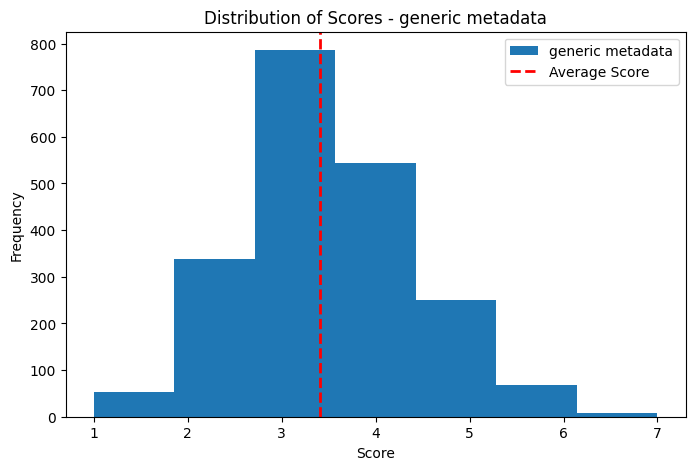

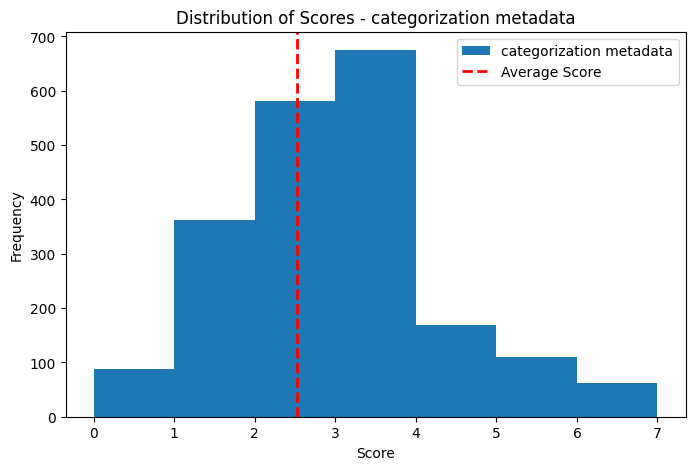

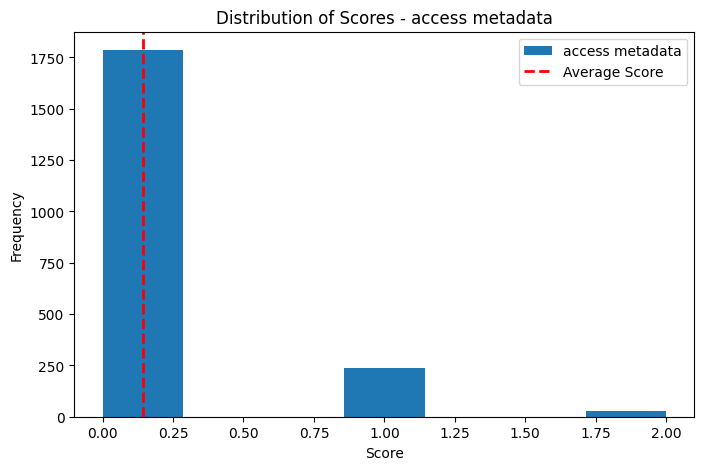

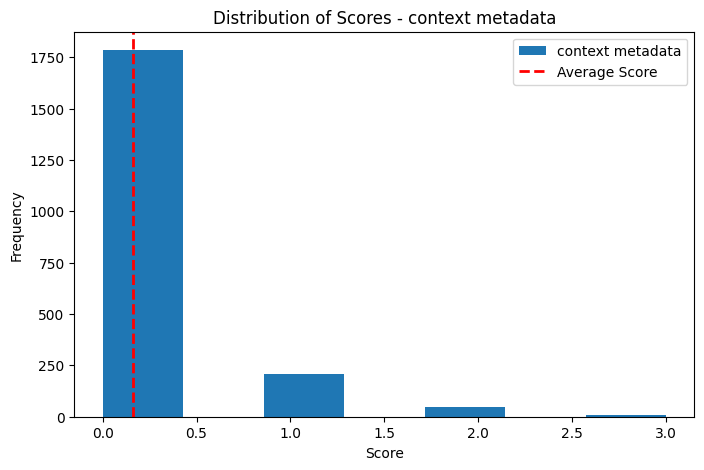

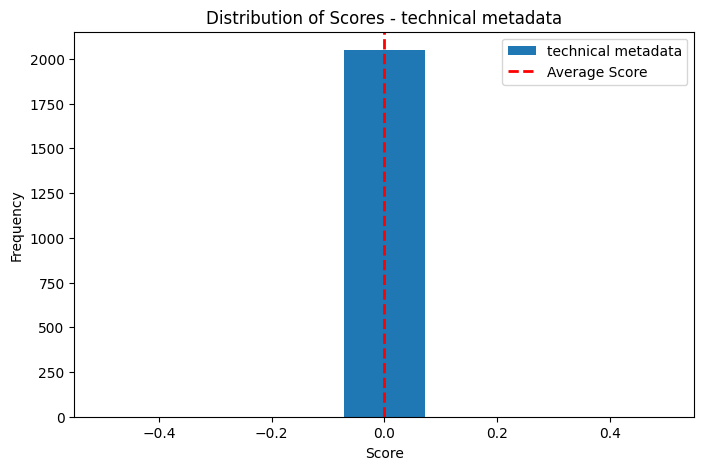

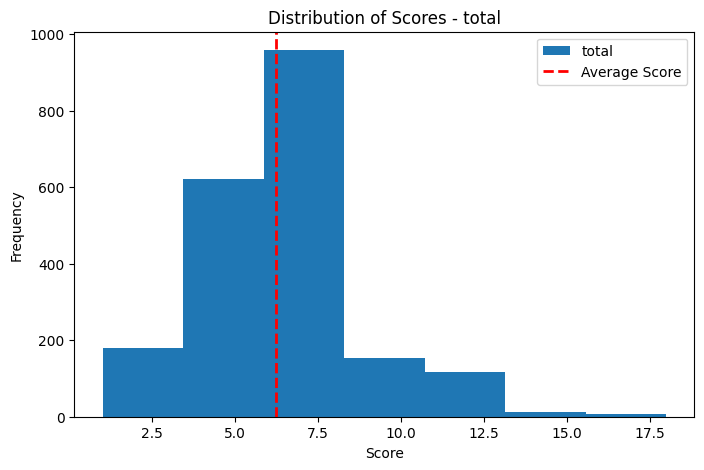

In [140]:
#print graph
import matplotlib.pyplot as plt

# Convert the "score" column to a DataFrame
df_tool_flat['score'] = df_tool_flat['score'].astype(str).apply(eval).apply(lambda x: {k: v for k, v in x.items() if k != 'max'})

# Create a DataFrame from the "score" column
score_df = pd.DataFrame(df_tool_flat['score'].tolist(), index=df_tool_flat.index)

# Plot the distribution for each category
for category in score_df.columns:
    plt.figure(figsize=(8, 5))
    score_df[category].plot(kind='hist', bins=7, title=f'Distribution of Scores - {category}')
    plt.axvline(score_df[category].mean(), color='r', linestyle='dashed', linewidth=2, label='Average Score')
    plt.legend()
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.show()

For the categories *general* and *categorization*, this produces useful results. For the categories *access* , *context* and *technical*, there are not enough metadata fields to produce meaningful graphs. 

An example of how this data can be applied to improve the Marketplace is the below function which finds tools below a given score threshold in one of the categories. These items can then be flagged for curation.

In [142]:
#Now I want to search for tools with low scores so I can flag them
def find_by_score(category, score):
    filtered_df = df_tool_flat[df_tool_flat['score'].apply(lambda x: x[category] <= score)]
    # Display the filtered DataFrame
    display(filtered_df)
find_by_score('categorization metadata', 1)

,id,category,label,persistentId,lastInfoUpdate,status,description,contributors,properties,externalIds,...,thumbnail.concept.vocabulary.scheme,thumbnail.concept.vocabulary.namespace,thumbnail.concept.vocabulary.label,thumbnail.concept.vocabulary.closed,thumbnail.concept.label,thumbnail.concept.notation,thumbnail.concept.uri,thumbnail.concept.candidate,md_score,score
1,36324,tool-or-service,3DF Zephyr - photogrammetry software - 3d mode...,4gDAHv,2022-01-13T11:49:02+0000,approved,3DF Zephyr\[1\]\[2\] is a commercial photogram...,[],"[{'type': {'code': 'language', 'label': 'Langu...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'flag_description': False, 'flag_contributors...","{'generic metadata': 3, 'categorization metada..."
3,36189,tool-or-service,3DReshaper \| 3DReshaper,kAkzuz,2022-01-13T11:47:44+0000,approved,No description provided.,[],"[{'type': {'code': 'language', 'label': 'Langu...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'flag_description': True, 'flag_contributors'...","{'generic metadata': 2, 'categorization metada..."
4,36213,tool-or-service,"3ds Max \| 3D Modeling, Animation \& Rendering...",9NKBY5,2022-01-13T11:47:53+0000,approved,"3ds Max is software for 3D modeling, animation...",[],"[{'type': {'code': 'language', 'label': 'Langu...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'flag_description': False, 'flag_contributors...","{'generic metadata': 3, 'categorization metada..."
9,36528,tool-or-service,A360 \| Project Collaboration in the Cloud,qbhnQw,2022-01-13T11:50:22+0000,approved,"A360 helps design, engineering, and project te...",[],"[{'type': {'code': 'language', 'label': 'Langu...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'flag_description': False, 'flag_contributors...","{'generic metadata': 4, 'categorization metada..."
17,55150,tool-or-service,aConCorde,05Kjwj,2023-10-13T18:51:57+0000,approved,This is a multi-lingual concordance tool. Orig...,[],"[{'type': {'code': 'keyword', 'label': 'Keywor...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'flag_description': False, 'flag_contributors...","{'generic metadata': 2, 'categorization metada..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018,29004,tool-or-service,Xournal,XVVPws,2021-11-23T17:40:05+0000,approved,"Xournal is an application for note-taking, ske...","[{'actor': {'id': 2842, 'name': 'N/A', 'extern...","[{'type': {'code': 'keyword', 'label': 'Keywor...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'flag_description': True, 'flag_contributors'...","{'generic metadata': 1, 'categorization metada..."
2030,40287,tool-or-service,YouTube,gNfOzz,2022-01-17T14:04:08+0000,approved,http://www.wikidata.org/entity/Q16971117,[],[],[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'flag_description': True, 'flag_contributors'...","{'generic metadata': 2, 'categorization metada..."
2032,47474,tool-or-service,YouTube Data Tools,CBl3qt,2022-11-03T15:23:31+0000,approved,YouTube Data Tools is a collection of simple u...,"[{'actor': {'id': 2290, 'name': 'Digital Metho...","[{'type': {'code': 'terms-of-use', 'label': 'T...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'flag_description': False, 'flag_contributors...","{'generic metadata': 3, 'categorization metada..."
2033,47475,tool-or-service,Youtube Scraper CSV Cleaner,e4PbnC,2022-11-03T15:23:31+0000,approved,A very simple/specialized piece of Java code t...,"[{'actor': {'id': 2166, 'name': 'Robert Budac'...","[{'type': {'code': 'terms-of-use', 'label': 'T...",[],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'flag_description': False, 'flag_contributors...","{'generic metadata': 3, 'categorization metada..."


## Further developments

This basic check gives the curation taskforce a tool to quickly identify metadata quality across the SSHOMP. It enables users to check the metadata quality of a given item against the metadata guidelines described in the MP documentation. When ran across all Tools and Serives in the MP, this tool provides an overall insight into the MD quality. 

Based off the current state of development, further developments are possible:

1. Integrate the logic of this basic check into the SSHOMP frontend, so that
   2. Curators have easy access to the Metadata score through the curation dashboard
   3. Users see the metadata score as they create or edit an item
   4. Use the score to filter search results so that items with high scores are preferred
2. Expand the scope of this basic check to cover all types of items in the SSHOMP
2. Expand the basic check to an advanced check
   1. Check not onyl *if* properties are there, but check number and (if possible), quality of references. For example, identify a preferred range of keywords and related items and check against that range
   2. Check all URLs
   3. Add a better way to check the description quality than just by length
3. Run the check periodically to document the development of MD over time.